In [2]:
# Import libraries
import pandas as pd
import random
import torch as th
from tqdm import tqdm

# Import Scripts
from Utils import ValidateModel
from Data_loaders import load_batch, User_vocab,Category_vocab,Subcategory_vocab , User_vali, UserData 

Data contains 17 topics and 237 subtopics


In [3]:
# Import Hparam
import yaml

# load dictionary
with open('MINDdemo_utils/lstur.yaml','r') as stream:
    hparams = yaml.safe_load(stream)


for key,val in hparams.items():
    print(key,":",val)

data : {'title_size': 30, 'his_size': 50, 'data_format': 'news', 'npratio': 4}
info : {'metrics': ['group_auc', 'mean_mrr', 'ndcg@5;10'], 'show_step': 100000}
model : {'attention_hidden_dim': 200, 'word_emb_dim': 300, 'dropout': 0.2, 'filter_num': 400, 'window_size': 3, 'cnn_activation': 'relu', 'gru_unit': 400, 'type': 'ini', 'model_type': 'lstur'}
train : {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.0001, 'loss': 'cross_entropy_loss', 'optimizer': 'adam', 'support_quick_scoring': True}


In [4]:
# Load Model
from LSTURini import LSTURini
from torch import nn,optim
device = "cuda" if th.cuda.is_available() else "mps"
max_history_length = 50


LSTUR_con_module = LSTURini(
    seq_len = max_history_length,
    user_dim=500,
    user_size=User_vocab.__len__(),
    topic_size=Category_vocab.__len__(),
    topic_dim=100,
    subtopic_size=Subcategory_vocab.__len__(),
    subtopic_dim=100,
    word_dim=300,
    device=device
)


#BatchSize = 400
#batches = 384 
#epochs = 10
#vali_batches = 177

BatchSize = 200
batches =  int(len(UserData)/BatchSize) 
epochs = 10
vali_batches = int(len(User_vali))


model = LSTUR_con_module.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
Softmax = nn.Softmax(dim=1)



In [5]:
model.train(False)
with th.no_grad():
    AUC_pre= 0
    MRR_pre= 0
    loss_pre = 0

    BatchLoader_vali = load_batch(User_vali, batch_size=1,train = False, device=device, shuffle=False)

    for _ in tqdm(range(vali_batches)):
        User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor, Impressions_len, Clicked = BatchLoader_vali.__next__()

        idx = Impressions_len.item()

        output = model(User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions[:,:idx], Subcategory_Impressions[:,:idx], Impressions_tensor[:,:idx])
        pred = Softmax(output)

        loss = loss_fn(output, Clicked)

        loss_pre += loss.item()/vali_batches

        AUC_score = ValidateModel.ROC_AUC(Clicked.item(), pred.detach().cpu()[0],Impressions_len.item())
        MRR_score = ValidateModel.mean_reciprocal_rank(Clicked.detach().cpu(), pred.detach().cpu()[0])

        AUC_pre += AUC_score/vali_batches
        MRR_pre += MRR_score.item()/vali_batches


print(f"Pre Training AUC: {AUC_pre}, MRR: {MRR_pre}, Loss: {loss_pre}")




100%|██████████| 7335/7335 [02:27<00:00, 49.84it/s]

Pre Training AUC: 0.5294686318514592, MRR: 0.21422651470229642, Loss: 5.8758424221320205


In [6]:
AUC = [AUC_pre]
MRR = [MRR_pre]
losses = []
loss_vali = [loss_pre]

for epoch in range(epochs):
# for epoch in range(10):
    model.train(True)
    optimizer.zero_grad()
    BatchLoader = load_batch(UserData, batch_size=BatchSize,train = True, device=device, shuffle=True)

    for _ in range(batches):
        User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor, Impressions_len, Clicked = BatchLoader.__next__()

        output = model(User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor)

        loss = loss_fn(output, Clicked)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        losses.append(loss.item())

        #print(f'Memory: {th.cuda.memory_reserved()/(10**9)} GB')
        #print(loss)
    model.train(False)    
    with th.no_grad():
        AUC_epoch = 0
        MRR_epoch = 0
        loss_vali_epoch = 0

        BatchLoader_vali = load_batch(User_vali, batch_size=1,train = False, device=device, shuffle=False)

        for _ in tqdm(range(vali_batches)):
            User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions, Subcategory_Impressions, Impressions_tensor, Impressions_len, Clicked = BatchLoader_vali.__next__()

            idx = Impressions_len.item()

            output = model(User_en, Category, Subcategory, History_tensor, history_len, Category_Impressions[:,:idx], Subcategory_Impressions[:,:idx], Impressions_tensor[:,:idx])
            pred = Softmax(output)

            loss = loss_fn(output, Clicked)

            loss_vali_epoch += loss.item()/vali_batches

            AUC_score = ValidateModel.ROC_AUC(Clicked.item(), pred.detach().cpu()[0],Impressions_len.item())
            MRR_score = ValidateModel.mean_reciprocal_rank(Clicked.detach(), pred.detach()[0])

            AUC_epoch += AUC_score/vali_batches
            MRR_epoch += MRR_score.item()/vali_batches

        loss_vali.append(loss_vali_epoch)
        AUC.append(AUC_epoch)
        MRR.append(MRR_epoch)

        # print("Validation")
        # Validation = ValidateModel(data_loader = load_batch, data = User_vali, batch_size=BatchSize, metrics = ['MRR','ROC_AUC'], device=device,train=False)
        # AUC_score, MRR_score, loss_vali_score = Validation.get_metrics(model, batches=vali_batches)

        # AUC.append(AUC_score)
        # MRR.append(MRR_score)
        # loss_vali.append(loss_vali_score)


    print(f'Memory: {th.cuda.memory_reserved()/(10**9)} GB')
    print(f"AUC: {AUC_epoch}. MRR: {MRR_epoch}. Loss: {loss_vali_epoch}.")



100%|██████████| 7335/7335 [02:23<00:00, 51.18it/s]


Memory: 3.552575488 GB
AUC: 0.5633584520147793. MRR: 0.21952752290175204. Loss: 4.427276981961616.


100%|██████████| 7335/7335 [02:26<00:00, 49.91it/s]


Memory: 3.552575488 GB
AUC: 0.572209763023356. MRR: 0.21666673934493763. Loss: 4.097370489611856.


  2%|▏         | 162/7335 [00:03<02:31, 47.32it/s]

NameError: name 'loss_vali' is not defined

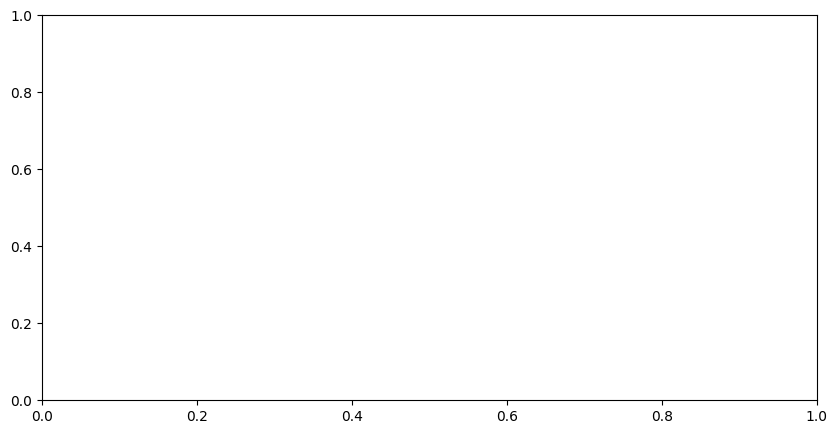

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.plot(loss_vali, label='Validation Loss')
axs.plot(np.linspace(0,10,len(losses)),losses,label = 'Training Loss')
axs.set_title('Loss')
axs.legend()
plt.show()


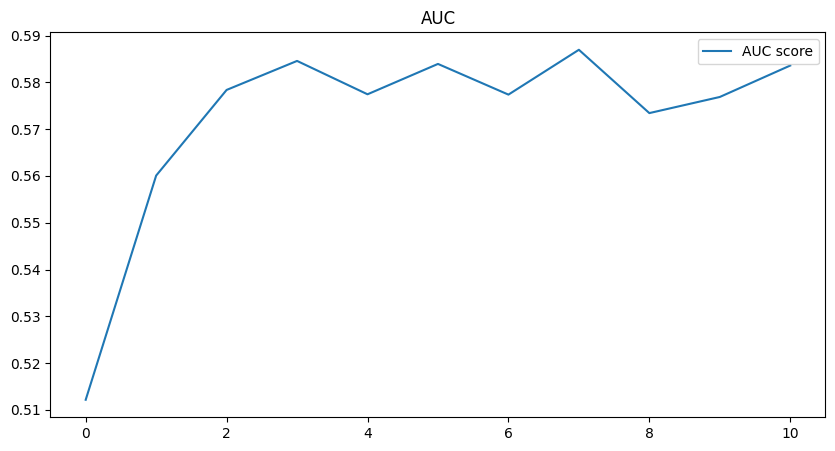

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.plot(AUC, label='AUC score')
axs.set_title('AUC')
axs.legend()
plt.show()

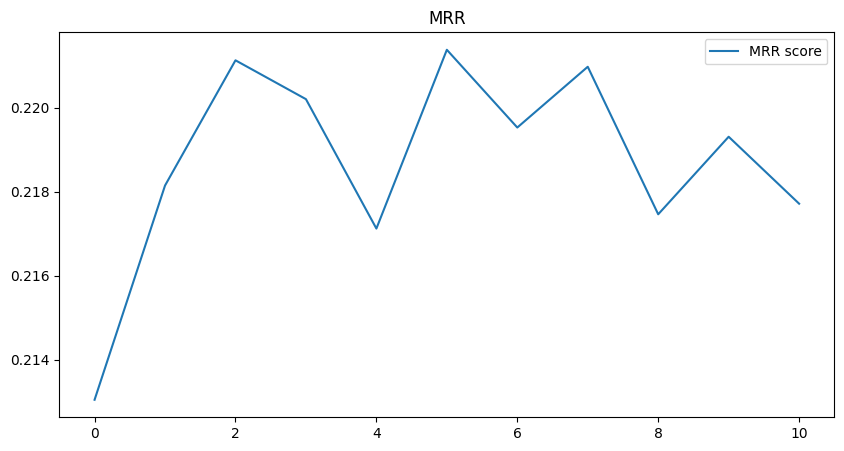

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(MRR, label='MRR score')
axs.set_title('MRR')
axs.legend()
plt.show()